# Exploratory Data Analysis (EDA) and Feature Engineering

This notebook performs EDA on the Malicious URL Detection dataset and implements feature engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from urllib.parse import urlparse

# Set plot style
sns.set(style="whitegrid")

## 1. Load and Inspect Data

In [2]:
file_path = "../data/raw/malicious_phish.csv"
import os
if os.path.exists(file_path):
    print("Good to go!")
else:
    print("File does not exist")

Good to go!


In [3]:
# Load dataset
df = pd.read_csv(file_path)

# Display first few rows
print("Dataset Head:")
display(df.head())

# Dataset Info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Class distribution
print("\nClass Distribution:")
print(df['type'].value_counts())

Dataset Head:


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None

Missing Values:
url     0
type    0
dtype: int64

Class Distribution:
type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64


## 2. Feature Engineering

We will extract the following features:
- `url_length`: Length of the URL
- `hostname_length`: Length of the hostname
- `ip_address`: Presence of IP address
- `count_special_chars`: Count of special characters
- `count_dirs`: Number of directories
- `count_embedded_domains`: Number of embedded domains
- `is_shortened`: Shortening service detection
- `sus_keywords`: Suspicious keywords
- `count_digits`: Number of digits
- `count_letters`: Number of letters
- `fd_length`: First directory length
- `tld_length`: Top-level domain length

In [4]:
def get_url_length(url):
    return len(url)

def get_hostname_length(url):
    return len(urlparse(url).netloc)

def get_ip_address(url):
    # Regex for IPv4
    match = re.search(r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\/)|'  # IPv4
                      r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)' # IPv4 in hexadecimal
                      r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url) # Ipv6
    if match:
        return 1
    else:
        return 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0

def get_count_special_chars(url):
    special_chars = ['.', '-', '/', '?', '%', '@', '=', '&', '_', '+', '!', '*', '(', ')', '$', ',']
    return sum(url.count(char) for char in special_chars)

def get_count_dirs(url):
    path = urlparse(url).path
    return path.count('/')

def get_count_embedded_domains(url):
    # Count occurrences of 'http', 'https', 'www' in the path or query, or just multiple 'http's
    # A simple heuristic is counting 'http' or 'https' and subtracting 1 (for the start)
    return max(0, url.count('http') - 1)

def get_is_shortened(url):
    shortening_services = r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|' \
                          r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|' \
                          r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|' \
                          r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|' \
                          r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|' \
                          r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|' \
                          r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|' \
                          r'tr\.im|link\.zip\.net'
    match = re.search(shortening_services, url, flags=re.IGNORECASE)
    return 1 if match else 0

def get_sus_keywords(url):
    keywords = ['login', 'update', 'free', 'paypal', 'secure', 'account', 'banking', 'confirm', 'signin', 'verify']
    return 1 if any(keyword in url.lower() for keyword in keywords) else 0

def get_count_digits(url):
    return sum(c.isdigit() for c in url)

def get_count_letters(url):
    return sum(c.isalpha() for c in url)

def get_fd_length(url):
    path = urlparse(url).path
    try:
        return len(path.split('/')[1])
    except IndexError:
        return 0

def get_tld_length(url):
    try:
        return len(urlparse(url).netloc.split('.')[-1])
    except:
        return 0

# Apply features
print("Extracting features... This may take a moment.")
df['url_length'] = df['url'].apply(get_url_length)
df['hostname_length'] = df['url'].apply(get_hostname_length)
df['ip_address'] = df['url'].apply(get_ip_address)
df['count_special_chars'] = df['url'].apply(get_count_special_chars)
df['count_dirs'] = df['url'].apply(get_count_dirs)
df['count_embedded_domains'] = df['url'].apply(get_count_embedded_domains)
df['is_shortened'] = df['url'].apply(get_is_shortened)
df['sus_keywords'] = df['url'].apply(get_sus_keywords)
df['count_digits'] = df['url'].apply(get_count_digits)
df['count_letters'] = df['url'].apply(get_count_letters)
df['fd_length'] = df['url'].apply(get_fd_length)
df['tld_length'] = df['url'].apply(get_tld_length)

print("Feature extraction complete.")
display(df.head())

Extracting features... This may take a moment.
Feature extraction complete.


,url,type,url_length,hostname_length,ip_address,count_special_chars,count_dirs,count_embedded_domains,is_shortened,sus_keywords,count_digits,count_letters,fd_length,tld_length
0,br-icloud.com.br,phishing,16,0,0,3,0,0,0,0,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0,0,5,2,0,0,0,1,29,5,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0,0,5,3,0,0,0,1,25,7,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,21,0,17,1,0,0,0,7,63,9,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,23,0,13,1,0,0,0,22,199,9,3


## 3. Visualization

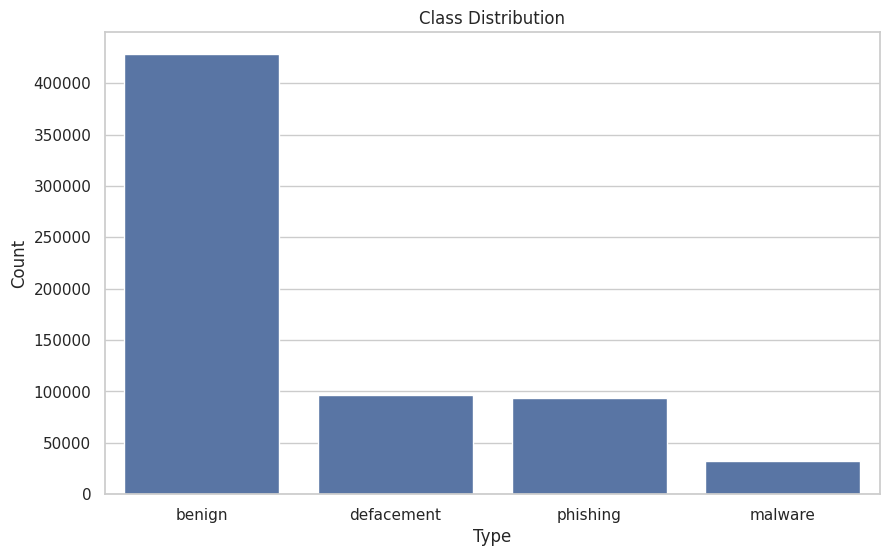

In [5]:
# Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=df, order=df['type'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

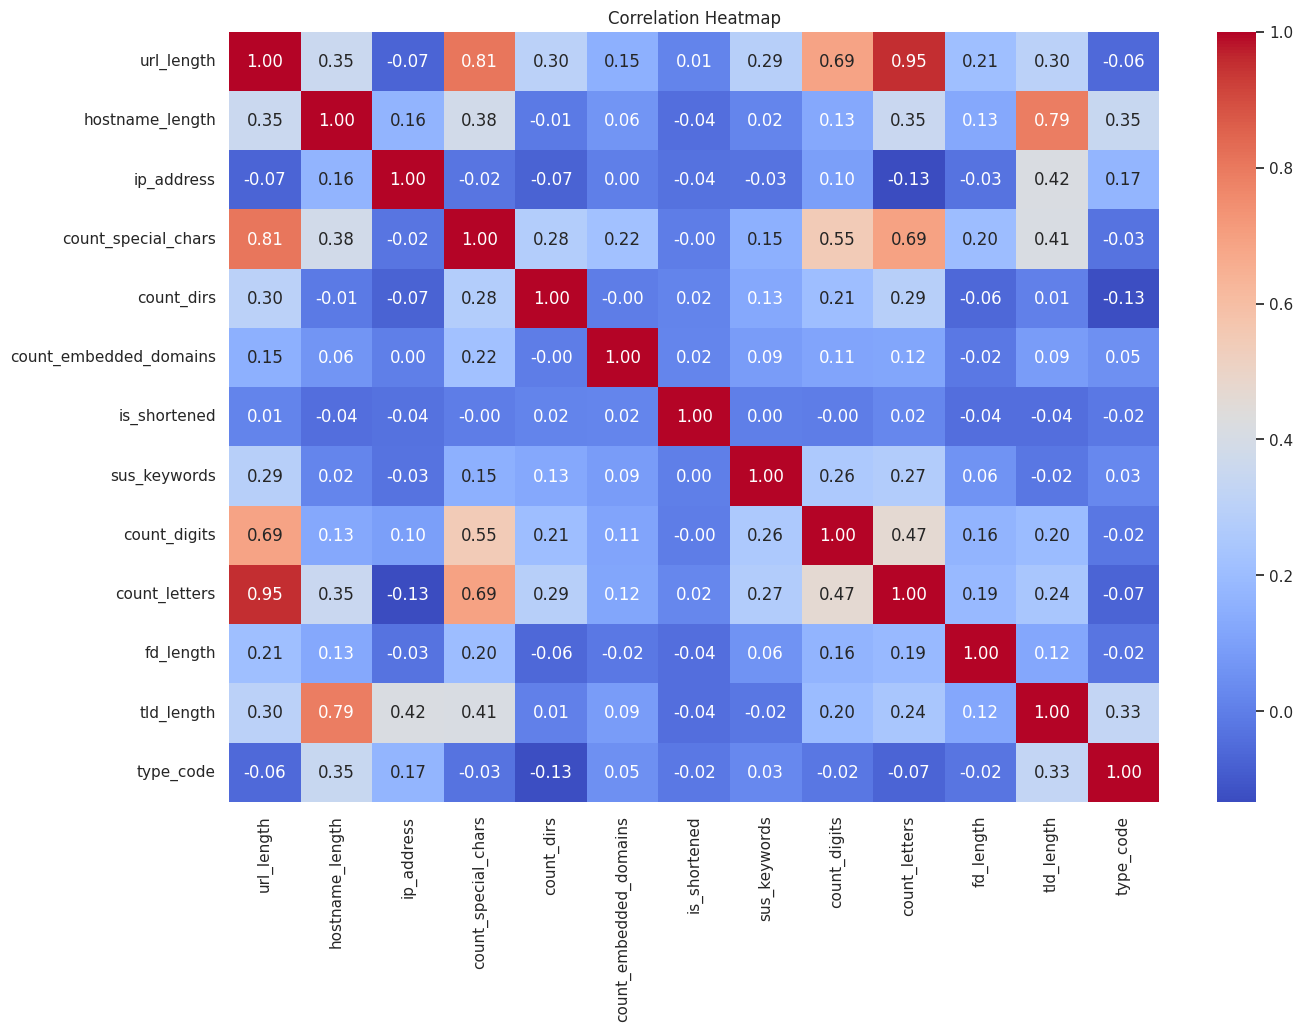

In [6]:
# Encode 'type' for correlation analysis
df['type_code'] = df['type'].astype('category').cat.codes

# Correlation Heatmap
plt.figure(figsize=(15, 10))
numerical_cols = ['url_length', 'hostname_length', 'ip_address', 'count_special_chars', 
                  'count_dirs', 'count_embedded_domains', 'is_shortened', 'sus_keywords', 
                  'count_digits', 'count_letters', 'fd_length', 'tld_length', 'type_code']
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

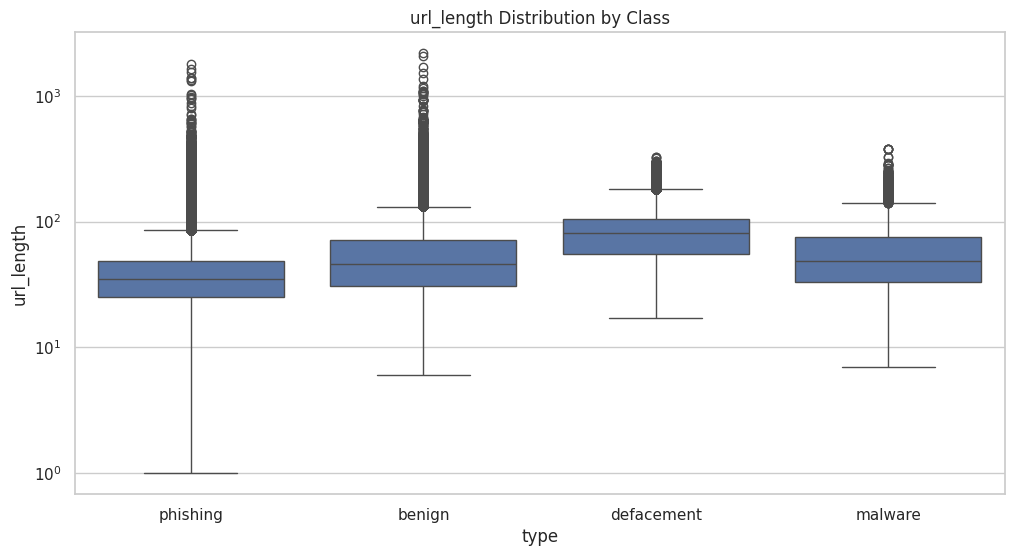

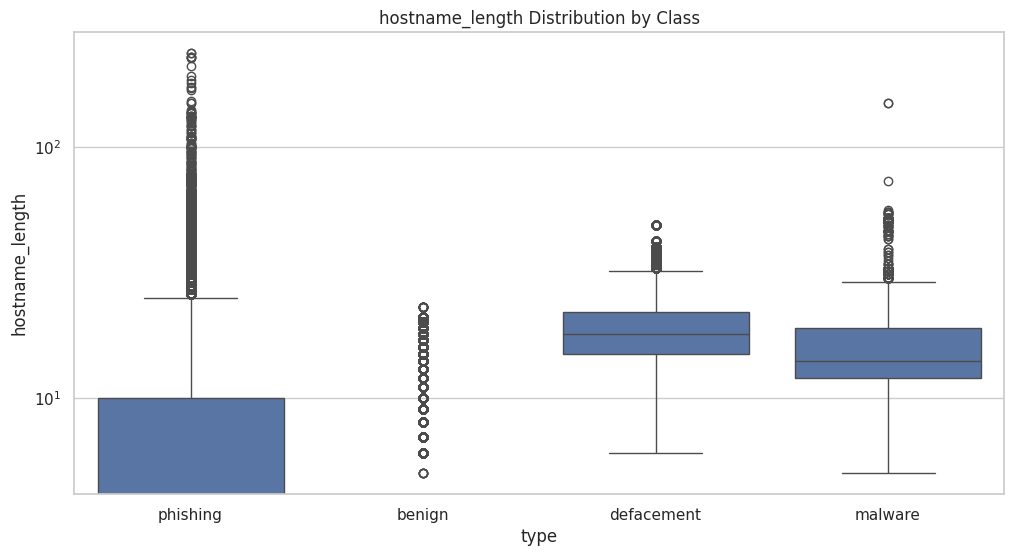

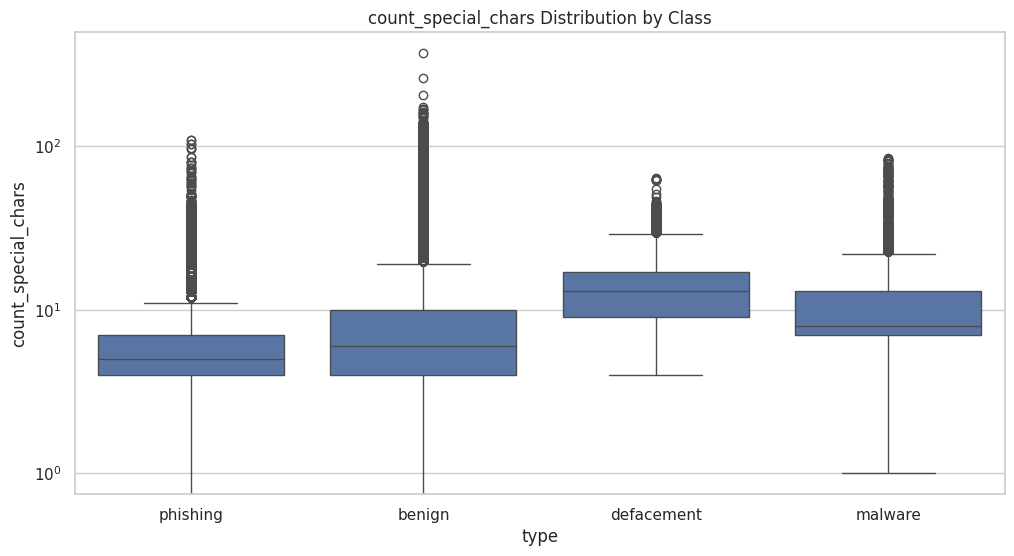

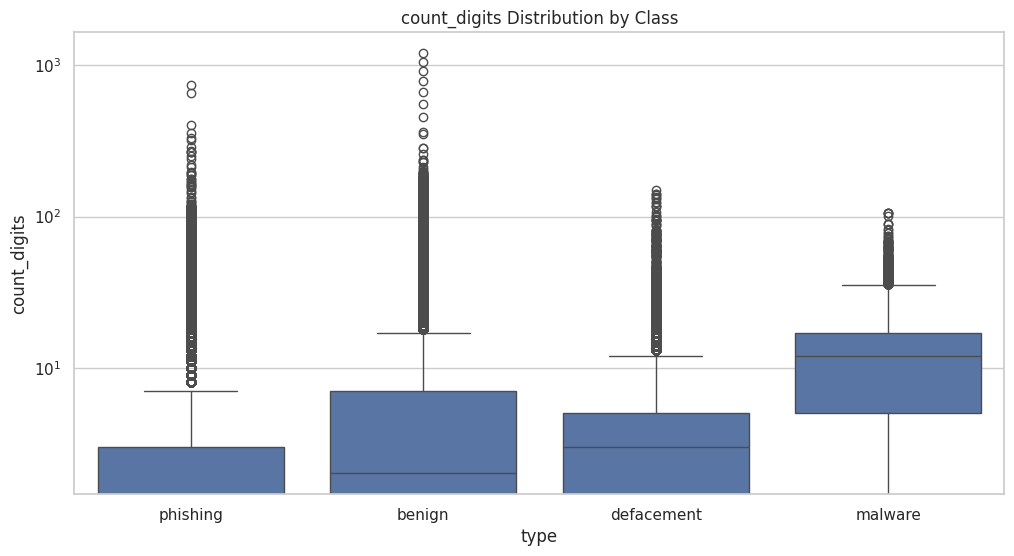

In [7]:
# Boxplots for key features
features_to_plot = ['url_length', 'hostname_length', 'count_special_chars', 'count_digits']

for feature in features_to_plot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='type', y=feature, data=df)
    plt.title(f'{feature} Distribution by Class')
    plt.yscale('log') 
    plt.show()

## 4. Save Processed Data 
We can save the processed dataframe with features for model training.

In [8]:
df.to_csv('../data/processed/malicious_phish_featured.csv', index=False)
print("Processed data saved.")

Processed data saved.
